## This is the Baseline Models Comparison and Selection

<font size="6" color="blue"> <B> I. Build models on raw data to have a feeling </B> </font> 

# 1. Load Librares

In [1]:
# this is Jupyter width setting
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.rcdefaults()
import warnings
%matplotlib inline
plt.style.use('ggplot')

# this is pandas table width setting
pd.set_option('display.max_columns', None)  

# display pd table side by side
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

# 2. Load the Data

In [2]:
# load train1, test1, rul1 pickle to have a test

train1 = pd.read_pickle('data/train1.pkl')
test1 = pd.read_pickle('data/test1.pkl')

train1_r5 = pd.read_pickle('data/train1_r5.pkl')
test1_r5 = pd.read_pickle('data/test1_r5.pkl')

train1_r5_norm = pd.read_pickle('data/train1_r5_norm.pkl')
test1_r5_norm = pd.read_pickle('data/test1_r5_norm.pkl')

In [3]:
train1[0:1]

,id,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,rul,w1,w2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.7,1400.6,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.419,191,0,0


In [4]:
train1_r5[0:1]

,id,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,rul,w1,w2
0,1.0,1.0,-0.0007,-0.0004,100.0,518.67,641.82,1589.7,1400.6,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392.0,2388.0,100.0,39.06,23.419,191,0,0


<font size="3" color="red"> <B> Remind: The test data need to pick one group for prediction at a time </B> </font> <br>
<font size="3" color="red"> <B> Remind: This is one of the tough point for the project </B> </font> 

In [6]:
# Prepare the training / testing data (raw data)

X_train, Y_train = train1.iloc[:,0:24], train1['rul']
X_test, Y_test = test1[test1['id']==100].iloc[:,0:24], test1[test1['id']==100]['rul']

X_train_r5, Y_train_r5 = train1_r5.iloc[:,0:24], train1_r5['rul']
X_test_r5, Y_test_r5 = test1_r5[test1_r5['id']==100].iloc[:,0:24], test1_r5[test1_r5['id']==100]['rul']

X_train_r5_norm, Y_train_r5_norm = train1_r5_norm.iloc[:,0:24], train1_r5_norm['rul']
X_test_r5_norm, Y_test_r5_norm = test1_r5_norm[test1_r5['id']==100].iloc[:,0:24], test1_r5_norm[test1_r5_norm['id']==100]['rul']

In [7]:
print(Y_test.count(), Y_test_r5.count(), Y_test_r5_norm.count())

198 198 198


<font size="6" color="blue"> <B> II. Regression </B> </font> 

### models
- linear regression
- LASSO
- ridge regression
- decision tree regression
- random forest regression

### Regression Support Functions

In [8]:
# define regression metrics calculation

from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn import metrics
def get_regression_metrics(model_name, model, x_train, y_train, x_test, y_test):
    '''Calculate regression performance metrics
    model_name (str):      model name
    model (clf):           model
    x_train:               training set
    y_train:               training label
    x_test:                testing set
    y_test (series):       testing label
    y_pred (series):       predict value will be generated within function
    returns:               combined metrics in a dataframe
    '''
    model.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_test)
    regression_metrics = {
        'explained variance':      metrics.explained_variance_score(y_test, y_pred),
        'root mean squared error': metrics.mean_squared_error(y_test, y_pred)**0.5,
        'mean absolute error':     metrics.mean_absolute_error(y_test, y_pred),
        'r2 score':                metrics.r2_score(y_test, y_pred)    }
    df_regression_metrics = pd.DataFrame.from_dict(regression_metrics, orient='index')
    df_regression_metrics.columns = [model_name]
    return df_regression_metrics

In [9]:
# define feature importance plot

def plot_feature_importance(model_name, model, x_train, y_train):
    '''Plot regression feature importance (coefficients weights)
    model (str):           model name
    weights (array):       coefficient weights
    f_names (list):        feature names
    weight_type (str):     'c' for coefficient weights, o.w. is feature importance
    returns:               plt of feature importance (coefficient weights)
    '''
    model.fit(x_train, y_train.values.ravel())
    if model_name == 'DecisionTr' or model_name == 'RandomFore':
        W = pd.DataFrame({'weights': model.feature_importances_}, x_train.columns)
    else:
        W = pd.DataFrame({'weights': model.coef_}, x_train.columns)        
    W.sort_values(by='weights', ascending=True).plot(kind='barh', color='r', figsize=(12, 5))
    label = ' feature importance' if (model_name == 'DecisionTr' or model_name == 'RandomFore') else ' coefficients'
    plt.xlabel(model_name + label)
    plt.show()

In [10]:
# define Grid Search Based hyper-parameter adjustment

from sklearn import model_selection
def best_model(model_name, model, x_train, y_train, x_test, params=None, score=None):
    grid_search = model_selection.GridSearchCV(estimator=model, param_grid=params, cv=5, scoring=score, n_jobs=-1)
    grid_search.fit(x_train, y_train)
    y_pred = grid_search.predict(x_test)
    if hasattr(grid_search, 'predict_proba'):
        y_score = grid_search.predict_prob(x_test)[:,1]
    elif hasattr(grid_search, 'decision_function'):
        y_score = grid_search.decision_function(x_test)
    else:
        y_score = y_pred
    predictions = {'y_pred': y_pred, 'y_score': y_score}
    df_predictions = pd.DataFrame.from_dict(predictions)
    return grid_search.best_estimator_, df_predictions, y_score

#### Regression Models

In [11]:
# linear regression
from sklearn import linear_model
lin_regr = linear_model.LinearRegression()

# LASSO regression
lasso_regr = linear_model.Lasso(alpha=0.001)

# ridge regression
rd_regr = linear_model.Ridge(alpha=0.01)

# decision tree regression
from sklearn.tree import DecisionTreeRegressor
dtr_regr = DecisionTreeRegressor(max_depth=7, random_state=123)

# random forest regression
from sklearn.ensemble import RandomForestRegressor
rf_regr = RandomForestRegressor(n_estimators=100, max_features=3, max_depth=4, n_jobs=-1, random_state=1)

# list of (models (clf), model names (str))
list_reg_model_name = [(str(m).split('(')[0][0:10], m) for m in [lin_regr, lasso_regr, rd_regr, dtr_regr, rf_regr]]

## 3.A Regression Based on Raw Data

In [12]:
# compare performance metrics

newDF = pd.DataFrame(index=['root mean squared error','mean absolute error','explained variance','r2 score'])
for name, model in list_reg_model_name:
    newDF = pd.concat([newDF, get_regression_metrics(name, model, X_train, Y_train, X_test, Y_test)], axis=1)

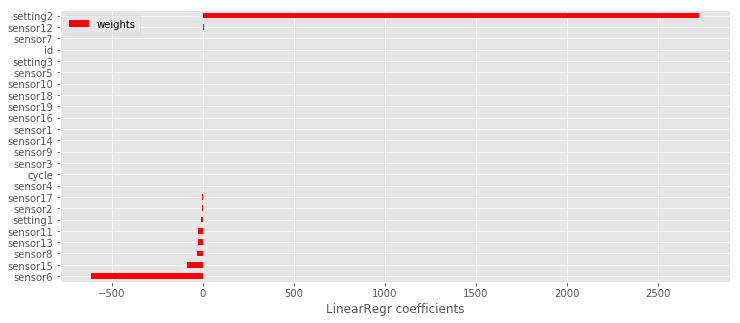

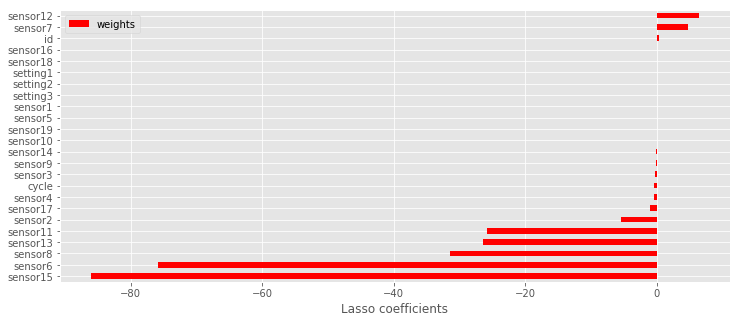

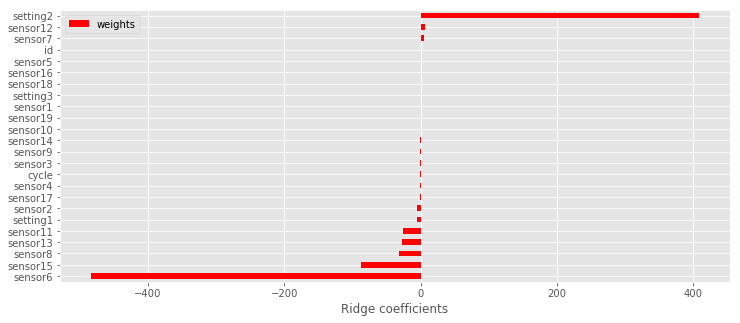

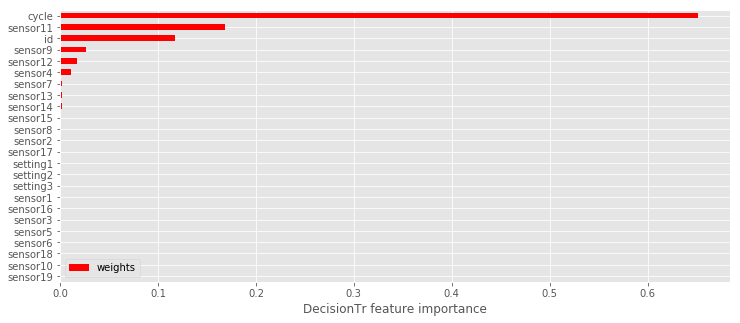

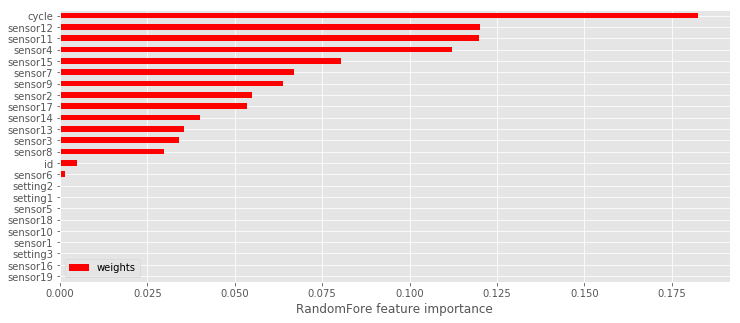

[None, None, None, None, None]

In [85]:
# Feature importance or coefficiency

[plot_feature_importance(name, model, X_train, Y_train) for name, model in list_reg_model_name]

## 3.B Regression Based on Rolling Data

In [13]:
# Window = 5, compare performance metrics

newDF_r5 = pd.DataFrame(index=['root mean squared error','mean absolute error','explained variance','r2 score'])
for name, model in list_reg_model_name:
    newDF_r5 = pd.concat([newDF_r5, get_regression_metrics(name, model, X_train_r5, Y_train_r5, X_test_r5, Y_test_r5)], axis=1)

## 3.C Regression Based on Normalized Rolling Data

In [14]:
# Rolling + Normalization performance metrics

newDF_r5_norm = pd.DataFrame(index=['root mean squared error','mean absolute error','explained variance','r2 score'])
for name, model in list_reg_model_name:
    newDF_r5_norm = pd.concat([newDF_r5_norm, get_regression_metrics(name, model, X_train_r5_norm, Y_train_r5_norm, X_test_r5_norm, Y_test_r5_norm)], axis=1)

In [34]:
# training data performance metrics

newDF_r5_norm_train = pd.DataFrame(index=['root mean squared error','mean absolute error','explained variance','r2 score'])
for name, model in list_reg_model_name:
    newDF_r5_norm_train = pd.concat([newDF_r5_norm_train, get_regression_metrics(name, model, X_train_r5_norm, Y_train_r5_norm, X_train_r5_norm, Y_train_r5_norm)], axis=1)
newDF_r5_norm_train

,LinearRegr,Lasso,Ridge,DecisionTr,RandomFore
explained variance,0.672618,0.665826,0.672618,0.838339,0.686609
mean absolute error,0.083893,0.084963,0.083893,0.053606,0.077373
r2 score,0.672618,0.665826,0.672618,0.838339,0.686609
root mean squared error,0.109171,0.110298,0.109171,0.076716,0.106813


### Results Side by Side

In [15]:
print('result side by side: Raw Data | Rolling Average (RA) | Normalization based on RA')
display_side_by_side(newDF,newDF_r5, newDF_r5_norm)

result side by side: Raw Data | Rolling Average (RA) | Normalization based on RA


,LinearRegr,Lasso,Ridge,DecisionTr,RandomFore
explained variance,0.883184,0.883090,0.882982,0.629537,0.768671
mean absolute error,29.719079,29.655633,29.657328,27.921237,26.862154
r2 score,0.643616,0.645843,0.645577,0.629219,0.718818
root mean squared error,34.121488,34.014736,34.027514,34.803901,30.308407
,LinearRegr,Lasso,Ridge,DecisionTr,RandomFore
explained variance,0.896884,0.896169,0.895782,0.828757,0.804240
mean absolute error,30.036391,29.839220,29.783577,21.082623,25.931935
r2 score,0.641824,0.650423,0.650766,0.808527,0.742472
root mean squared error,34.207158,33.794087,33.777469,25.010530,29.005554
,LinearRegr,Lasso,Ridge,DecisionTr,RandomFore


## 3.D Regression Summary
## Linear Regression as a Baseline 
- Results:
    - Rolling average performs better than raw data
    - Normalization + Rolling performs better again in r2 score
- Next steps:
    - Based on hypaparameter tuning to develope a model to beat the baseline

## 3.D Hyper Parameter Adjust, Choose Baseline
- From previous practice:
    - Rolling average and feature normalization brings better result
    - RandomForest has more robust performance than the rest
- Now making hyper parameter adjustment to choose the regression baseline

In [16]:
# best_model(model_name, model, x_train, y_train, x_test, params=None, score=None):
    
clf_name = 'random forest'
clf_rf = RandomForestRegressor(random_state=1, min_samples_split=2)
rf_param = {'n_estimators': [4,5,6], 'max_depth': [4,5,6]}
rf_score = 'r2'
clf_rf, Y_pred, Y_score = best_model(clf_name, clf_rf, X_train_r5_norm, Y_train_r5_norm, 
                                     X_test_r5_norm, params=rf_param, score=rf_score)
print('best parameters:\n', clf_rf)

best parameters:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)


In [22]:
clf_rf2 = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease =1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=5, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)
clf_rf2.fit(X_train_r5_norm, Y_train_r5_norm)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=1e-07, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [23]:
# hyper-parameter tuning works! way better than the best model earlier

get_regression_metrics(clf_name, clf_rf2, X_train_r5_norm, Y_train_r5_norm, X_test_r5_norm, Y_test_r5_norm)

,random forest
explained variance,0.944001
root mean squared error,0.043226
mean absolute error,0.031863
r2 score,0.936578


In [31]:
rf_regr.get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 4,
 'max_features': 3,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# linear regression
from sklearn import linear_model
lin_regr = linear_model.LinearRegression()

# LASSO regression
lasso_regr = linear_model.Lasso(alpha=0.001)

# ridge regression
rd_regr = linear_model.Ridge(alpha=0.01)

# decision tree regression
from sklearn.tree import DecisionTreeRegressor
dtr_regr = DecisionTreeRegressor(max_depth=7, random_state=123)

# random forest regression
from sklearn.ensemble import RandomForestRegressor
rf_regr = RandomForestRegressor(n_estimators=100, max_features=3, max_depth=4, n_jobs=-1, random_state=1)

# list of (models (clf), model names (str))
list_reg_model_name = [(str(m).split('(')[0][0:10], m) for m in [lin_regr, lasso_regr, rd_regr, dtr_regr, rf_regr]]

<font size="6" color="blue"> <B> I. Build models on raw data to have a feeling </B> </font> 

# 4. Binary Classifications
- logistic regression
- decision tree
- random forest
- support vector machine
- k nearest neighbor

In [19]:
# train/test data definition for binary

X_train_b, Y_train_b = train1.iloc[:,2:19], train1.iloc[:,20:21]
X_test_b, Y_test_b = test1.iloc[:,2:19], test1.iloc[:,21:22]

### 4.A Binary Classification Support Functions

In [20]:
# define binary metrics calculation

from sklearn import metrics
def get_binary_metrics(model_name, model, x_train, y_train, x_test, y_test):
    '''Calculate binary classification performance metrics
    model_name (str):      model name
    model (clf):           model
    x_train:               training set
    y_train:               training label
    x_test:                testing set
    y_test (series):       testing label
    y_pred (series):       predict value will be generated within function
    returns:               combined metrics in a dataframe
    '''
    model.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_test)
    binary_metrics = {
        'accuracy':                metrics.accuracy_score(y_test, y_pred),
        'Precision':               metrics.precision_score(y_test, y_pred),
        'Recall':                  metrics.recall_score(y_test, y_pred),
        'f1 score':                metrics.f1_score(y_test, y_pred),
        'ROC AUC':                 metrics.roc_auc_score(y_test, y_pred) 
    }
    df_binary_metrics = pd.DataFrame.from_dict(binary_metrics, orient='index')
    df_binary_metrics.columns = [model_name]
    return df_binary_metrics

### 4.B Load Models

In [21]:
# logistic regression
from sklearn.linear_model import LogisticRegression
clf_lg_b = LogisticRegression(random_state=123)

# decision trees
from sklearn.tree import DecisionTreeClassifier, export_graphviz
clf_dt_b = DecisionTreeClassifier(random_state=123)

# random forest
from sklearn.ensemble import RandomForestClassifier
clf_rf_b = RandomForestClassifier(n_estimators=50, random_state=123)

# support vector machine
from sklearn.svm import SVC
clf_svc_b = SVC(kernel='rbf', random_state=123)

# k nearest neighbor
from sklearn.neighbors import KNeighborsClassifier
clf_knn_b = KNeighborsClassifier(n_jobs=-1)

# list of (models (clf), model names (str))
list_bin_model_name = [(str(m).split('(')[0][0:10], m) for m in [clf_lg_b, clf_dt_b, clf_rf_b, clf_svc_b, clf_knn_b]]

### 4.C Compare Model Performance

In [22]:
# compare performance metrics

newDF_bin = pd.DataFrame(index=['accuracy','Precision','Recall', 'f1 score', 'ROC AUC'])
for name, model in list_bin_model_name:
    newDF_bin = pd.concat([newDF_bin, get_binary_metrics(name, model, X_train_b, Y_train_b, X_test_b, Y_test_b)], axis=1)
newDF_bin

,LogisticRe,DecisionTr,RandomFore,SVC,KNeighbors
Precision,0.745614,0.532764,0.829167,0.753191,0.657993
ROC AUC,0.753752,0.775202,0.798093,0.764294,0.762962
Recall,0.512048,0.563253,0.599398,0.533133,0.533133
accuracy,0.983201,0.976405,0.986714,0.983735,0.981139
f1 score,0.607143,0.547584,0.695804,0.624339,0.589018


### 4.E Binary Classification Summary
- Accuracy for binary classification is better than regression
- Insights:
    - RandomForest model looks better performance
- Next Step:
    - Feature Engineering
    - hyper-parameter tuning (Grid search)

# 5. Multi-Class Classifications
- logistic regression
- decision tree
- random forest
- support vector machine (linear svc)
- k nearest neigbor (knn)
- neural network (MLP multi-layer perceptron)

In [23]:
# train/test data definition for multi-class

X_train_m, Y_train_m = train1.iloc[:,2:19], train1.iloc[:,21:22]
X_test_m, Y_test_m = test1.iloc[:,2:19], test1.iloc[:,22:23]

### 5.A Multi-Class Classification Support Functions

In [24]:
# define multi-class metrics calculation

from sklearn import metrics
def get_multi_metrics(model_name, model, x_train, y_train, x_test, y_test):
    '''Calculate multi-class classification performance metrics
    model_name (str):      model name
    model (clf):           model
    x_train:               training set
    y_train:               training label
    x_test:                testing set
    y_test (series):       testing label
    y_pred (series):       predict value will be generated within function
    returns:               combined metrics in a dataframe
    '''
    model.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_test)
    multi_metrics = {
        'accuracy':                metrics.accuracy_score(y_test, y_pred),
        'macro F1':                metrics.f1_score(y_test, y_pred, average='macro'),
        'micro F1':                metrics.f1_score(y_test, y_pred, average='micro'),
        'macro Precision':         metrics.precision_score(y_test, y_pred,  average='macro'),
        'micro Precision':         metrics.precision_score(y_test, y_pred,  average='micro'),
        'macro Recall':            metrics.recall_score(y_test, y_pred,  average='macro'),
        'micro Recall':            metrics.recall_score(y_test, y_pred,  average='micro')   
    }
    df_multi_metrics = pd.DataFrame.from_dict(multi_metrics, orient='index')
    df_multi_metrics.columns = [model_name]
    return df_multi_metrics

### 5.B Load Models

In [25]:
# logistic regression
from sklearn.linear_model import LogisticRegression
clf_lg_m = LogisticRegression(random_state=123)

# decision trees
from sklearn.tree import DecisionTreeClassifier, export_graphviz
clf_dt_m = DecisionTreeClassifier(random_state=123)

# random forest
from sklearn.ensemble import RandomForestClassifier
clf_rf_m = RandomForestClassifier(n_estimators=50, random_state=123)

# support vector machine
from sklearn.svm import SVC
clf_svc_m = SVC(kernel='rbf', random_state=123)

# k nearest neighbor
from sklearn.neighbors import KNeighborsClassifier
clf_knn_m = KNeighborsClassifier(n_jobs=-1)

# neural network
from sklearn.neural_network import MLPClassifier
clf_nn_m = MLPClassifier(random_state=123)

# list of (models (clf), model names (str))
list_multi_model_name = [(str(m).split('(')[0][0:10], m) for m in [clf_lg_m, clf_dt_m, clf_rf_m, clf_svc_m, clf_knn_m, clf_nn_m]]

### 5.C Compare Model Performance

In [28]:
# compare performance metrics
# too few data caused some warnings, ignore it

newDF_mul = pd.DataFrame(index=['accuracy','macro F1','micro F1','macro Precision','micro Precision','macro Recall','micro Recall'])
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for name, model in list_multi_model_name:
        newDF_mul = pd.concat([newDF_mul, get_multi_metrics(name, model, X_train_m, Y_train_m, X_test_m, Y_test_m)], axis=1)
newDF_mul

,LogisticRe,DecisionTr,RandomFore,SVC,KNeighbors,MLPClassif
accuracy,0.976710,0.975489,0.983201,0.978619,0.977474,0.974649
macro F1,0.489040,0.633160,0.718793,0.591133,0.606923,0.329054
macro Precision,0.778457,0.615023,0.788519,0.657734,0.645569,0.324883
macro Recall,0.567474,0.665344,0.670847,0.569406,0.587005,0.333333
micro F1,0.976710,0.975489,0.983201,0.978619,0.977474,0.974649
micro Precision,0.976710,0.975489,0.983201,0.978619,0.977474,0.974649
micro Recall,0.976710,0.975489,0.983201,0.978619,0.977474,0.974649


### 5.D Multi-Class Classification Insights
- On raw data, Random forest performs strong among all classifiers
- Next step:
    - Feature engineering
    - hyper-parameter tuning (Grid search)
    - Compare the performance again

# 6. Review of All Models

In [29]:
print('Regressors')
newDF

Regressors


,LinearRegr,Lasso,Ridge,DecisionTr,RandomFore
explained variance,0.337138,0.337516,0.337424,0.339755,0.351758
mean absolute error,37.163542,37.151975,37.154635,36.353867,36.766395
r2 score,0.327030,0.327385,0.327301,0.335055,0.330541
root mean squared error,48.382349,48.369585,48.372582,48.093018,48.255980


In [30]:
print('Binary Classifiers')
newDF_bin

Binary Classifiers


,LogisticRe,DecisionTr,RandomFore,SVC,KNeighbors
Precision,0.745614,0.532764,0.829167,0.753191,0.657993
ROC AUC,0.753752,0.775202,0.798093,0.764294,0.762962
Recall,0.512048,0.563253,0.599398,0.533133,0.533133
accuracy,0.983201,0.976405,0.986714,0.983735,0.981139
f1 score,0.607143,0.547584,0.695804,0.624339,0.589018


In [31]:
print('Multi-class Classifiers')
newDF_mul

Multi-class Classifiers


,LogisticRe,DecisionTr,RandomFore,SVC,KNeighbors,MLPClassif
accuracy,0.976710,0.975489,0.983201,0.978619,0.977474,0.974649
macro F1,0.489040,0.633160,0.718793,0.591133,0.606923,0.329054
macro Precision,0.778457,0.615023,0.788519,0.657734,0.645569,0.324883
macro Recall,0.567474,0.665344,0.670847,0.569406,0.587005,0.333333
micro F1,0.976710,0.975489,0.983201,0.978619,0.977474,0.974649
micro Precision,0.976710,0.975489,0.983201,0.978619,0.977474,0.974649
micro Recall,0.976710,0.975489,0.983201,0.978619,0.977474,0.974649


## The Performance looks Poor, will use tuned Data to get a more valid baseline

<font size="6" color="blue"> <B> II. Used Normalized Data to Build Baseline </B> </font> 

#### Load Data

In [102]:
train1_norm = pd.read_pickle('data/train1_norm.pkl')
test1_norm = pd.read_pickle('data/test1_norm.pkl')

In [103]:
train1_norm[0:1]

,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,rul,w1,w2
0,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,0.529086,0,0


In [104]:
test1_norm[0:1]

,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,rul,w1,w2
0,0.596215,0.421968,0.282214,0.608871,0.365854,0.196475,0.273973,0.534247,0.325581,0.152259,0.347076,0.375,0.5,0.620099,0.405405,0,0


# 7. Regressions

In [108]:
# train/test data definition

X_train_norm, Y_train_norm = train1_norm.iloc[:,0:14], train1_norm.iloc[:,14:15]
X_test_norm, Y_test_norm = test1_norm.iloc[:,0:14], test1_norm.iloc[:,14:15]

### 7.1 Performance Metrics

In [113]:
# compare performance metrics

newDF1 = pd.DataFrame(index=['root mean squared error','mean absolute error','explained variance','r2 score'])
for name, model in list_reg_model_name:
    newDF1 = pd.concat([newDF1, get_regression_metrics(name, model, X_train_norm, Y_train_norm, X_test_norm, Y_test_norm)], axis=1)
newDF1

,LinearRegr,Lasso,Ridge,DecisionTr,RandomFore
explained variance,0.353918,0.341556,0.353917,0.220747,0.311276
mean absolute error,0.150269,0.143588,0.150268,0.202980,0.166861
r2 score,-0.212995,-0.137826,-0.212982,-0.964120,-0.446187
root mean squared error,0.195063,0.188922,0.195062,0.248215,0.212989


In [94]:
newDF

,LinearRegr,Lasso,Ridge,DecisionTr,RandomFore
explained variance,0.337138,0.337516,0.337424,0.339755,0.351758
mean absolute error,37.163542,37.151975,37.154635,36.353867,36.766395
r2 score,0.327030,0.327385,0.327301,0.335055,0.330541
root mean squared error,48.382349,48.369585,48.372582,48.093018,48.255980


In [162]:
train1_roll = pd.read_pickle('data/train1_roll.pkl')
test1_roll = pd.read_pickle('data/test1_roll.pkl')

In [165]:
# train/test data definition

X_train_roll, Y_train_roll = train1_roll.iloc[:,0:14], train1_roll.iloc[:,14:15]
X_test_roll, Y_test_roll = test1_roll.iloc[:,0:14], test1_roll.iloc[:,14:15]

In [166]:
# Rolling data - compare performance metrics

newDF2 = pd.DataFrame(index=['root mean squared error','mean absolute error','explained variance','r2 score'])
for name, model in list_reg_model_name:
    newDF2 = pd.concat([newDF2, get_regression_metrics(name, model, X_train_roll, Y_train_roll, X_test_roll, Y_test_roll)], axis=1)
newDF2

C:\Users\ericx\AppData\Local\conda\conda\envs\PY35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


,LinearRegr,Lasso,Ridge,DecisionTr,RandomFore
explained variance,0.340907,0.341138,0.340925,0.302676,0.379824
mean absolute error,36.742989,36.742614,36.743047,37.436834,35.426055
r2 score,0.333559,0.333752,0.333574,0.300039,0.370392
root mean squared error,48.147066,48.140114,48.146518,49.343037,46.797667


In [168]:
from sklearn import preprocessing
scaler_train = preprocessing.MinMaxScaler()
scaler_test = preprocessing.MinMaxScaler()
train1_roll_norm = pd.DataFrame(scaler_train.fit_transform(train1_roll), columns=train1_roll.columns)
test1_roll_norm = pd.DataFrame(scaler_test.fit_transform(test1_roll), columns=test1_roll.columns)

In [171]:
X_train_roll_norm, Y_train_roll_norm = train1_roll_norm.iloc[:,0:14], train1_roll_norm.iloc[:,14:15]
X_test_roll_norm, Y_test_roll_norm = test1_roll_norm.iloc[:,0:14], test1_roll_norm.iloc[:,14:15]

In [172]:
# Rolling data - compare performance metrics

newDF3 = pd.DataFrame(index=['root mean squared error','mean absolute error','explained variance','r2 score'])
for name, model in list_reg_model_name:
    newDF3 = pd.concat([newDF3, get_regression_metrics(name, model, X_train_roll_norm, Y_train_roll_norm, X_test_roll_norm, Y_test_roll_norm)], axis=1)
newDF3

,LinearRegr,Lasso,Ridge,DecisionTr,RandomFore
explained variance,0.348552,0.343909,0.348561,0.228424,0.357617
mean absolute error,0.119914,0.126522,0.119917,0.156498,0.135816
r2 score,0.160106,0.080820,0.160061,-0.301454,-0.043021
root mean squared error,0.162314,0.169803,0.162319,0.202050,0.180880


In [132]:
dd_train = pd.read_csv('data/train.csv', sep = ',')
dd_test = pd.read_csv('data/test.csv', sep = ',')

In [154]:
features_corrl = ['s2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20','s21']
label_corrl = ['ttf']

In [152]:
dd_train[features_corrl][0:1]

,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,641.82,1589.7,1400.6,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.419


In [155]:
dd_train[label_corrl][0:1]

,ttf
0,191


In [139]:
# linear regression
from sklearn import linear_model
lin1 = linear_model.LinearRegression()

# LASSO regression
lasso1 = linear_model.Lasso(alpha=0.001)

In [156]:
lin1.fit(dd_train[features_corrl], dd_train[label_corrl])
Y_tr_pred = lin1.predict(dd_test[features_corrl])

In [161]:
# metrics.explained_variance_score(dd_train[label_corrl], Y_tr_pred)

In [160]:
# metrics.r2_score(dd_train[label_corrl], Y_tr_pred) 

# 8. Binary Classification

In [ ]:
        'explained variance':      metrics.explained_variance_score(y_test, y_pred),
        'root mean squared error': metrics.mean_squared_error(y_test, y_pred)**0.5,
        'mean absolute error':     metrics.mean_absolute_error(y_test, y_pred),
        'r2 score':                metrics.r2_score(y_test, y_pred) 

# 9. Multi-Class Classification